# Malaria Cell Classification with Grad-CAM
This notebook trains a CNN to classify malaria-infected cell images and visualizes **class activation maps (Grad-CAM)**.

## Install Kaggle API and Download Dataset
We need the Kaggle API to download the dataset of malaria-infected and uninfected cell images.


In [ ]:
# Install Kaggle API and torch_snippets
!pip install -q kaggle
!pip install -U -q torch_snippets

from google.colab import files

# Upload kaggle.json file with API credentials
files.upload()

# Set up credentials for Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!ls ~/.kaggle

# Download and extract dataset
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -qq cell-images-for-detecting-malaria.zip

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.3/110.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 66.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 111.5 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 97% 656M/675M [00:01<00:00, 286MB/s]
100% 675M/675M [00:01<00:00, 379MB/s]


## Import Required Libraries
We import common libraries for image processing, data handling, PyTorch deep learning, and visualization.

In [ ]:
import cv2
import glob
import random
import numpy as np

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from sklearn.model_selection import train_test_split
from torch_snippets import logger, parent, fname, read, Report, resize, subplots

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

## Class Mapping
We define integer labels for the two classes in the dataset.

In [ ]:
id2int = {"Parasitized": 0, "Uninfected": 1}

## Define Transformations
- **Training**: Includes augmentations like color jitter, affine transformations.
- **Validation**: Only resizing and normalization, no augmentation.


In [ ]:
# Training transformations
trn_tfms = T.Compose(
    [
        T.ToPILImage(),
        T.Resize(128),
        T.CenterCrop(128),
        T.ColorJitter(
            brightness=(0.95, 1.05),
            contrast=(0.95, 1.05),
            saturation=(0.95, 1.05),
            hue=0.05,
        ),
        T.RandomAffine(5, translate=(0.01, 0.1)),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

# Validation transformations
val_tfms = T.Compose(
    [
        T.ToPILImage(),
        T.Resize(128),
        T.CenterCrop(128),
        T.ToTensor(),
        T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ]
)

## Dataset Class
We create a PyTorch Dataset class to:
- Load images and labels
- Apply transformations
- Provide a custom `collate_fn` for the DataLoader

In [ ]:
class MalariaImages(Dataset):
    """PyTorch Dataset for Malaria Cell Images"""

    def __init__(self, files, transform=None):
        self.files = files
        self.transform = transform
        logger.info(len(self))  # Log dataset size

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fpath = self.files[idx]
        clss = fname(parent(fpath))  # Extract class name from path
        img = read(fpath, 1)  # Read image in BGR format
        return img, clss

    def choose(self):
        # Randomly select an image
        return self[random.randint(len(self))]

    def collate_fn(self, batch):
        """
        Custom collate function for DataLoader
        Returns:
            imgs: batch of transformed images
            classes: labels as tensors
            _imgs: original images
        """
        _imgs, classes = list(zip(*batch))
        if self.transform:
            imgs = [self.transform(img)[None] for img in _imgs]
            classes = [torch.tensor([id2int[clss]]) for clss in classes]
            imgs, classes = [torch.cat(i).to(device) for i in [imgs, classes]]
            return imgs, classes, _imgs

## Prepare DataLoaders
- Shuffle dataset
- Split into training and validation
- Create PyTorch DataLoaders with batch size 32


In [ ]:
# Fetch all image paths
all_files = glob.glob("cell_images/*/*.png")
np.random.seed(10)
np.random.shuffle(all_files)

# Train/Validation split
trn_files, val_files = train_test_split(all_files, random_state=1)

# Dataset and DataLoader
trn_ds = MalariaImages(trn_files, transform=trn_tfms)
val_ds = MalariaImages(val_files, transform=val_tfms)
trn_dl = DataLoader(trn_ds, 32, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, 32, shuffle=False, collate_fn=val_ds.collate_fn)

[11/09/25 10:07:59] INFO     20668                                                                                                    ]8;id=521825;file:///tmp/ipython-input-1077029347.py:7\ipython-input-1077029347.py]8;;\:]8;id=697572;file:///tmp/ipython-input-1077029347.py:7#__init__:7\__init__:7]8;;\

                    INFO     6890                                                                                                     ]8;id=207016;file:///tmp/ipython-input-1077029347.py:7\ipython-input-1077029347.py]8;;\:]8;id=623692;file:///tmp/ipython-input-1077029347.py:7#__init__:7\__init__:7]8;;\

## Define Malaria Classifier
- Uses multiple convolutional blocks
- Flatten -> Fully connected layers
- Output: 2 classes (Parasitized / Uninfected)


In [ ]:
def convBlock(ni, no):
    """Convolutional block with Conv -> ReLU -> BatchNorm -> MaxPool"""
    return nn.Sequential(
        nn.Dropout(0.2),
        nn.Conv2d(ni, no, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2),
    )


class MalariaClassifier(nn.Module):
    """CNN model for classifying malaria-infected cells"""

    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            convBlock(3, 64),
            convBlock(64, 64),
            convBlock(64, 128),
            convBlock(128, 256),
            convBlock(256, 512),
            convBlock(512, 64),
            nn.Flatten(),
            nn.Linear(256, 256),
            nn.Dropout(0.2),
            nn.ReLU(inplace=True),
            nn.Linear(256, len(id2int)),
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def compute_metrics(self, preds, targets):
        """Compute loss and accuracy"""
        loss = self.loss_fn(preds, targets)
        acc = (torch.max(preds, 1)[1] == targets).float().mean()
        return loss, acc

## Batch Training and Validation Functions
Encapsulate single-batch training and validation.


In [ ]:
def train_batch(model, data, optimizer, criterion):
    """Train model on a single batch"""
    model.train()
    imgs, labels, _ = data
    preds = model(imgs)
    optimizer.zero_grad()
    loss, acc = criterion(preds, labels)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()


@torch.no_grad()
def validate_batch(model, data, criterion):
    """Validate model on a single batch"""
    model.eval()
    imgs, labels, _ = data
    preds = model(imgs)
    loss, acc = criterion(preds, labels)
    return loss.item(), acc.item()

## Train the CNN Model
- 10 epochs for training
- Track training and validation metrics

In [ ]:
model = MalariaClassifier().to(device)
criterion = model.compute_metrics
optimizer = Adam(model.parameters(), lr=1e-3)
n_epochs = 10

log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for idx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(epoch + (idx + 1) / N, trn_loss=loss, trn_acc=acc, end="\r")

    N = len(val_dl)
    for idx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(epoch + (idx + 1) / N, val_loss=loss, val_acc=acc, end="\r")

    log.report_avgs(epoch + 1)

EPOCH: 1.000  val_loss: 0.209  trn_loss: 0.235  trn_acc: 0.911  val_acc: 0.935  (139.49s - 1255.42s remaining)
EPOCH: 2.000  val_loss: 0.159  trn_loss: 0.173  trn_acc: 0.945  val_acc: 0.954  (264.39s - 1057.57s remaining)
EPOCH: 3.000  val_loss: 0.159  trn_loss: 0.162  trn_acc: 0.948  val_acc: 0.948  (389.70s - 909.30s remaining)
EPOCH: 4.000  val_loss: 0.151  trn_loss: 0.159  trn_acc: 0.947  val_acc: 0.952  (515.59s - 773.39s remaining)
EPOCH: 5.000  val_loss: 0.126  trn_loss: 0.153  trn_acc: 0.949  val_acc: 0.957  (638.96s - 638.96s remaining)
EPOCH: 5.029  trn_loss: 0.122  trn_acc: 0.938  (641.99s - 634.48s remaining)

## Extract Feature Maps for Grad-CAM
We extract the convolutional layer outputs from the 5th convBlock to compute class activation maps.


In [ ]:
img2fmap = nn.Sequential(
    *(list(model.model[:5].children()) + list(model.model[5][:2].children()))
)

## Grad-CAM Function
Computes activation heatmaps highlighting regions important for classification.


In [ ]:
def img2gradCAM(x):
    """Compute Grad-CAM heatmap for a single image"""
    model.eval()
    logits = model(x)
    activations = img2fmap(x)
    print(activations.shape)
    pred = logits.max(-1)[-1]  # Predicted class index

    model.zero_grad()
    logits[0, pred].backward(retain_graph=True)

    # Compute average gradients for each feature map
    pooled_grads = model.model[-6][1].weight.grad.data.mean((1, 2, 3))

    # Weight activations by average gradients
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_grads[i]

    # Compute final heatmap
    heatmap = torch.mean(activations, dim=1)[0]
    heatmap = torch.relu(heatmap)
    heatmap = heatmap.cpu().detach()

    return heatmap, "Uninfected" if pred.item() else "Parasitized"

## Overlay Heatmap
Resize Grad-CAM heatmap and overlay on original image for visualization.


In [ ]:
SZ = 128


def upsampleHeatmap(map, img):
    """Resize and overlay heatmap on original image"""
    m, M = map.min(), map.max()
    map = 255 * ((map - m) / (M - m))
    map = np.uint8(map)
    map = cv2.resize(255 - map, (SZ, SZ))
    map = cv2.applyColorMap(map, cv2.COLORMAP_JET)
    map = np.uint8(map * 0.7 + img * 0.3)
    return map

## Visualize Grad-CAM on Validation Images
Display original image alongside the Grad-CAM heatmap for infected cells.


torch.Size([1, 64, 4, 4])


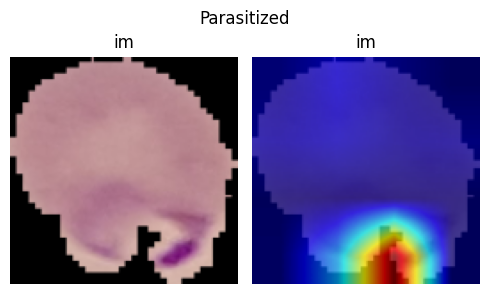

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


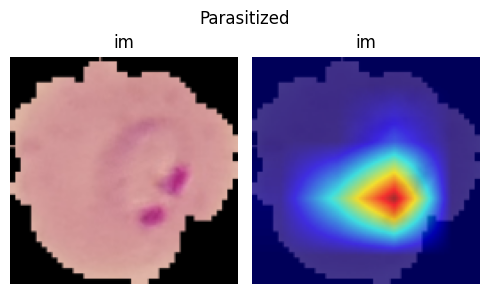

torch.Size([1, 64, 4, 4])


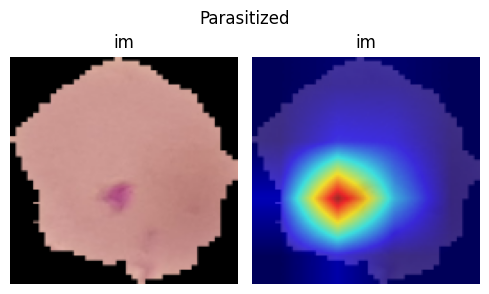

torch.Size([1, 64, 4, 4])


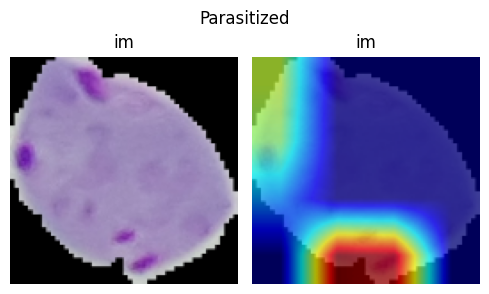

torch.Size([1, 64, 4, 4])


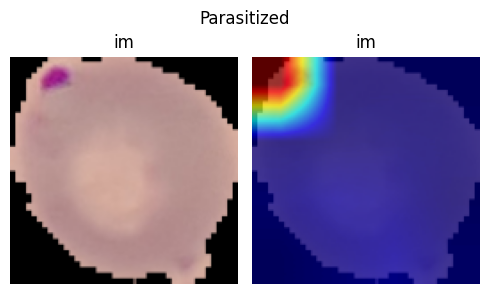

torch.Size([1, 64, 4, 4])


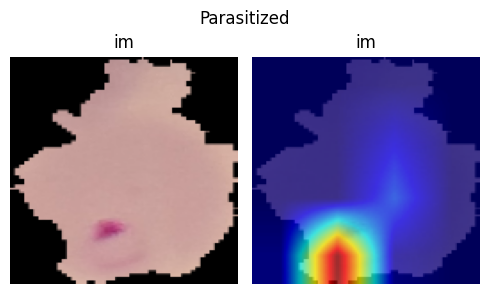

torch.Size([1, 64, 4, 4])


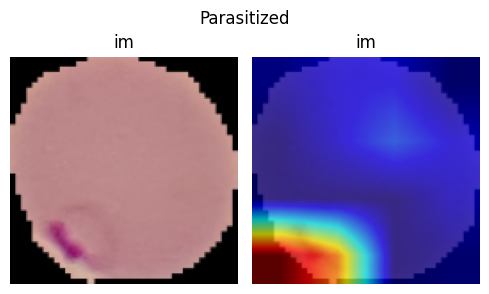

torch.Size([1, 64, 4, 4])


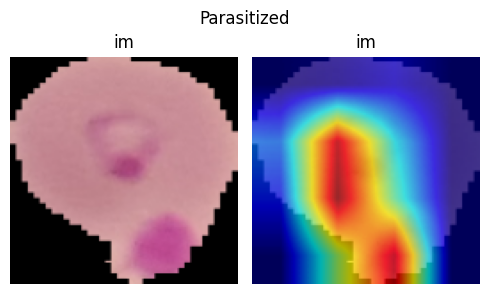

torch.Size([1, 64, 4, 4])


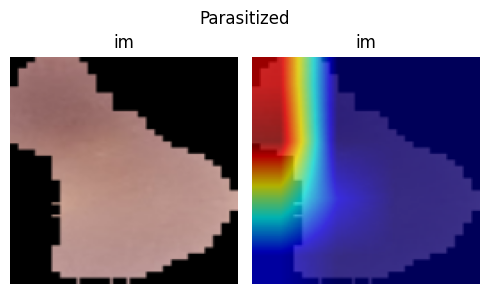

torch.Size([1, 64, 4, 4])


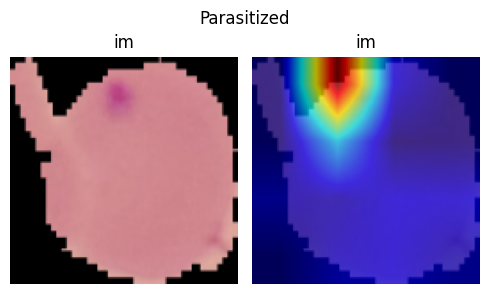

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


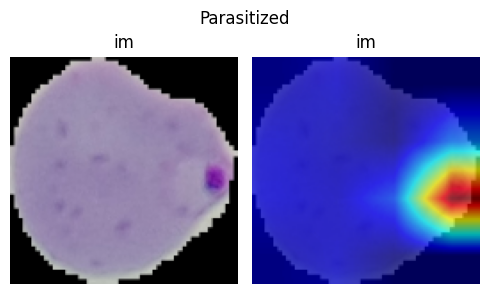

torch.Size([1, 64, 4, 4])


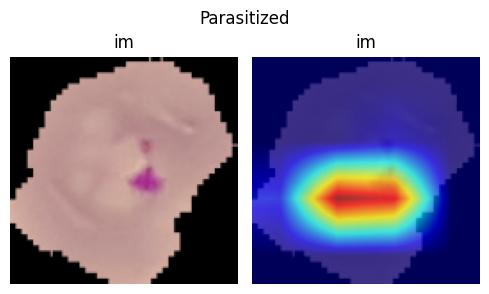

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


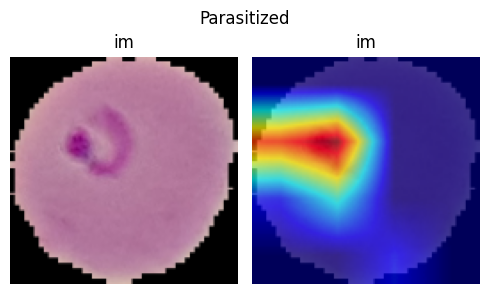

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


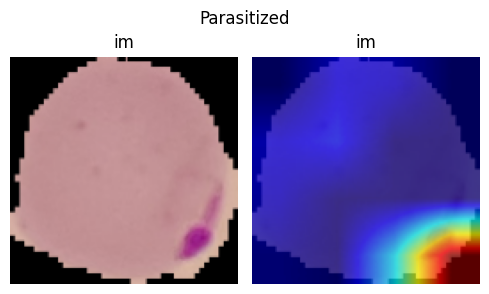

torch.Size([1, 64, 4, 4])


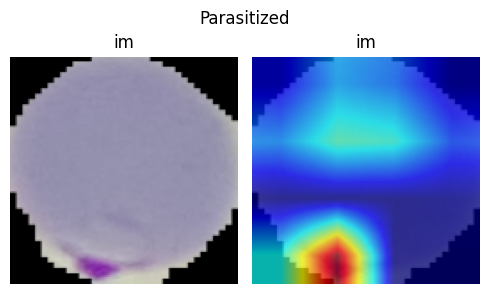

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


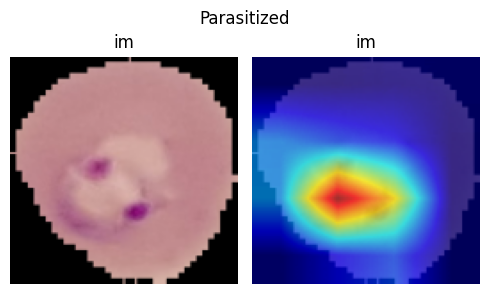

torch.Size([1, 64, 4, 4])


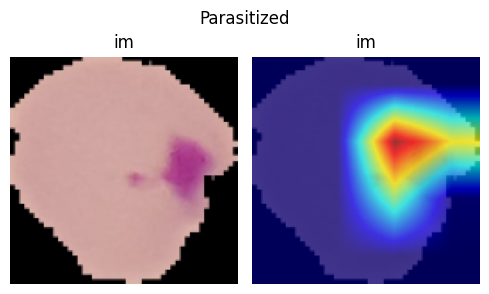

torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])
torch.Size([1, 64, 4, 4])


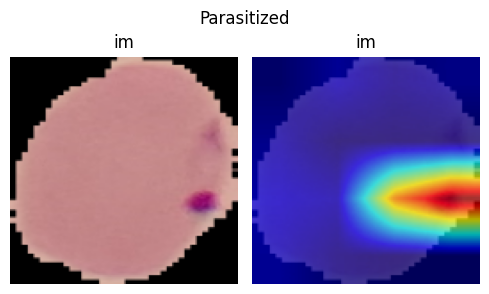

In [ ]:
N = 30
_val_dl = DataLoader(val_ds, batch_size=N, shuffle=True, collate_fn=val_ds.collate_fn)
x, y, z = next(iter(_val_dl))

for i in range(N):
    image = resize(z[i], SZ)
    heatmap, pred = img2gradCAM(x[i : i + 1])
    if pred == "Uninfected":
        continue
    heatmap = upsampleHeatmap(heatmap, image)
    subplots([image, heatmap], nc=2, figsize=(5, 3), suptitle=pred)